In [2]:
import pandas as pd
import numpy as np

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [3]:
import sqlite3


conn = sqlite3.connect("db.sqlite3")
cursor = conn.cursor()

query = """
    SELECT
    restaurant_orderitem.id AS id, 
    restaurant_orderitem.quantity, 
    restaurant_order.datetime AS datetime, 
    restaurant_product.price AS price, 
    restaurant_product.name AS name
    FROM restaurant_orderitem
    INNER JOIN restaurant_order ON restaurant_orderitem.order_id = restaurant_order.id
    INNER JOIN restaurant_product ON restaurant_orderitem.product_id = restaurant_product.id;
"""

combined_csv_file = "restaurant_data.csv"
pd.read_sql_query(query, conn).to_csv(combined_csv_file, index=False)

conn.close()

combined_df = pd.read_csv(combined_csv_file)
dtype_mapping = {
    "quantity": np.int32,
    "price": np.float16,
    "name": str,
}
parse_dates = ["datetime"]
pd.read_csv("restaurant_data.csv", dtype=dtype_mapping, parse_dates=parse_dates)

,id,quantity,datetime,price,name
0,1,2,2019-08-03 20:25:00,0.799805,Plain Papadum
1,2,1,2019-08-03 20:25:00,12.953125,King Prawn Balti
2,3,1,2019-08-03 20:25:00,2.949219,Garlic Naan
3,4,1,2019-08-03 20:25:00,3.949219,Mushroom Rice
4,5,1,2019-08-03 20:25:00,8.953125,Paneer Tikka Masala
...,...,...,...,...,...
74813,74814,2,2016-05-18 18:53:00,17.953125,House Red wine 75cl
74814,74815,2,2016-05-14 19:28:00,17.953125,House Red wine 75cl
74815,74816,2,2016-05-10 13:18:00,17.953125,House Red wine 75cl
74816,74817,1,2016-04-07 19:04:00,17.953125,House white wine 75cl


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

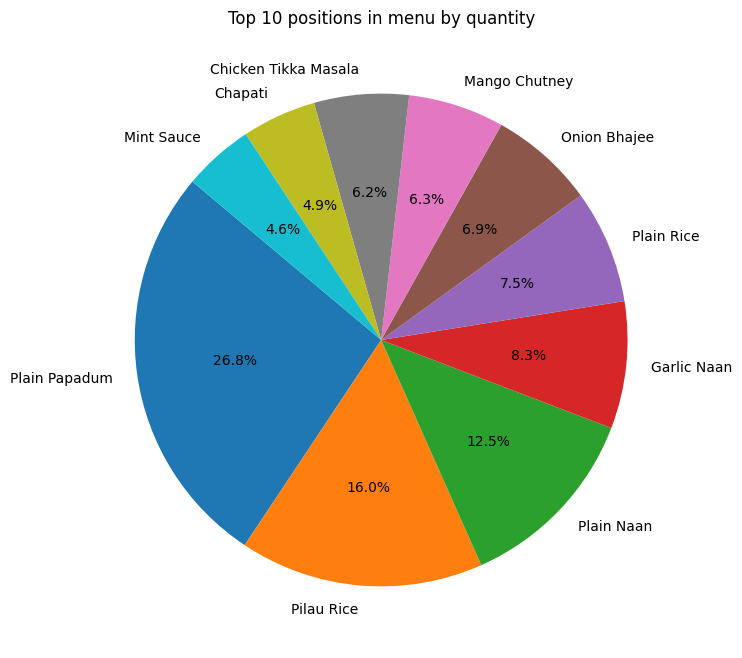

In [4]:
import matplotlib.pyplot as plt

popular_product = combined_df.groupby("name")["quantity"].sum()
sorted_products = popular_product.sort_values(ascending=False)
top_10_products = sorted_products.head(10)
percentage_popularity = (top_10_products / top_10_products.sum()) * 100
plt.figure(figsize=(8, 8))
plt.pie(percentage_popularity, labels=top_10_products.index, autopct="%1.1f%%", startangle=140)
plt.title("Top 10 positions in menu by quantity")

plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

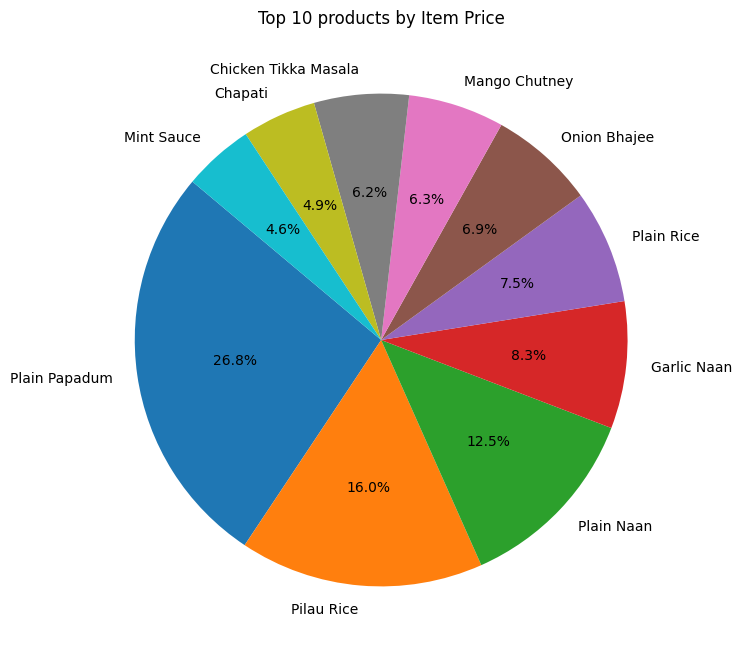

In [5]:
combined_df["item-price"] = combined_df["price"] * combined_df["quantity"]
popular_product_price = combined_df.groupby("name")["item-price"].sum()
sorted_price = popular_product_price.sort_values(ascending=False)
top_10_price = sorted_price.head(10)
percentage_price = (top_10_price / top_10_price.sum()) * 100
plt.figure(figsize=(8, 8))
plt.pie(percentage_popularity, labels=top_10_products.index, autopct="%1.1f%%", startangle=140)
plt.title("Top 10 products by Item Price")

plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

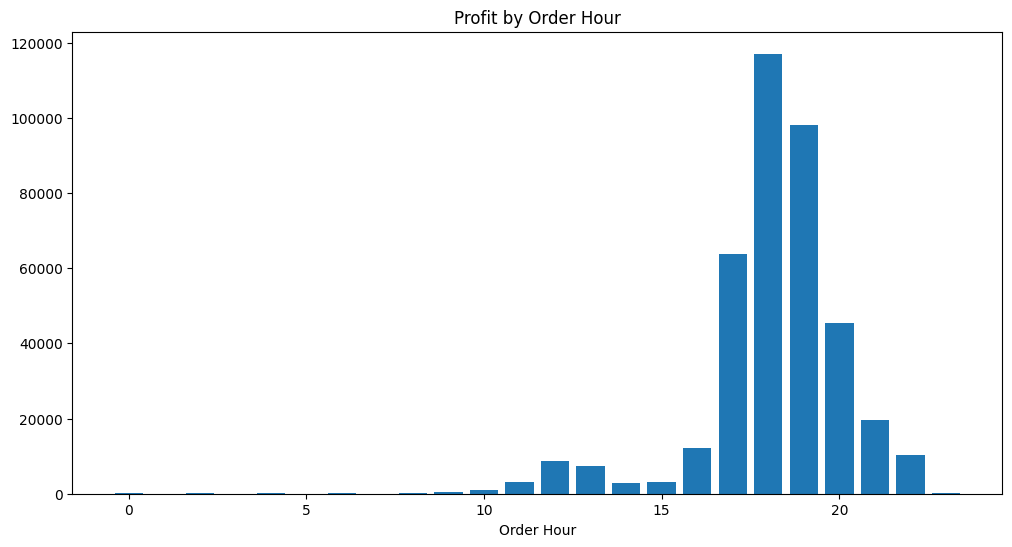

In [6]:
combined_df["datetime"] = pd.to_datetime(combined_df["datetime"])
combined_df["order_hour"] = combined_df["datetime"].dt.hour
hourly_income = combined_df.groupby("order_hour")["price"].sum()
plt.figure(figsize=(12, 6))
plt.bar(hourly_income.index, hourly_income)
plt.xlabel("Order Hour")
plt.title("Profit by Order Hour")

plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

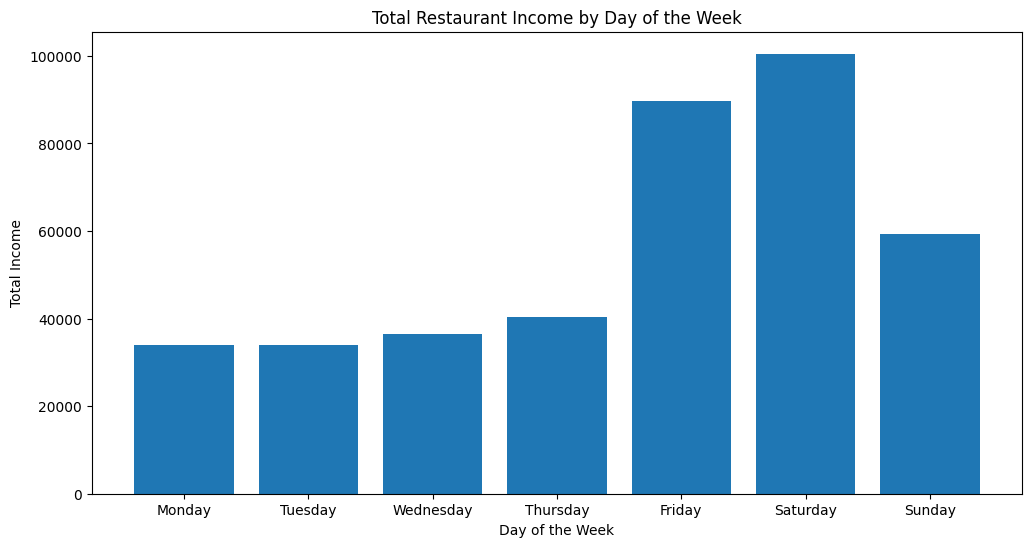

In [7]:
combined_df["datetime"] = pd.to_datetime(combined_df["datetime"])
combined_df["order_day_of_week"] = combined_df["datetime"].dt.dayofweek
daily_income = combined_df.groupby("order_day_of_week")["price"].sum()
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize=(12, 6))
plt.bar(day_names, daily_income)
plt.xlabel("Day of the Week")
plt.ylabel("Total Income")
plt.title("Total Restaurant Income by Day of the Week")

plt.show()